In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
base_path = Path('/content/drive/MyDrive/ml_data')

In [ ]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

# 1. Podstawowa analiza danych

Liczba wierszy i kolumn

In [ ]:
print("Rozmiar zbioru:", titanic_df.shape)

Rozmiar zbioru: (891, 11)


Podgląd pierwszych wierszy

In [ ]:
display(titanic_df.head())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Typy kolumn i liczba niepustych wartości

In [ ]:
titanic_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      793 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Statystyki dla zmiennych numerycznych

In [ ]:
display(titanic_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.000,0.0,1.000,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.000,3.0,3.000,3.0000
Age,714.0,29.699118,14.526497,0.42,20.125,28.0,38.000,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.000,0.0,1.000,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.000,0.0,0.000,6.0000
Fare,793.0,33.123938,51.578312,0.00,7.925,14.5,31.275,512.3292


Statystyki dla zmiennych tekstowych/kategorialnych

In [ ]:
display(titanic_df.describe(include="object").T)

,count,unique,top,freq
Name,891,891,"Dooley, Mr. Patrick",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,G6,4
Embarked,889,3,S,644


Liczba unikalnych wartości w każdej kolumnie

In [ ]:
unique_counts = titanic_df.nunique().sort_values(ascending=False)
print("\nLiczba unikalnych wartości w kolumnach:")
print(unique_counts)


Liczba unikalnych wartości w kolumnach:
Name        891
Ticket      681
Fare        236
Cabin       147
Age          88
SibSp         7
Parch         7
Embarked      3
Pclass        3
Survived      2
Sex           2
dtype: int64


# 2. Sprawdzenie braków danych i imputacja

In [ ]:
def missing_summary(data):
    miss = data.isnull().sum()
    miss_pct = (miss / len(data) * 100).round(2)
    return pd.DataFrame({'missing_count': miss, 'missing_pct': miss_pct}).sort_values(by='missing_count', ascending=False)

print("Braki przed imputacją:")
display(missing_summary(titanic_df))

Braki przed imputacją:


,missing_count,missing_pct
Cabin,687,77.10
Age,177,19.87
Fare,98,11.00
Embarked,2,0.22
Name,0,0.00
Survived,0,0.00
Pclass,0,0.00
Parch,0,0.00
SibSp,0,0.00
Sex,0,0.00


Ekstrakcja tytułu (Title) z imienia

In [ ]:
def extract_title(name):
    match = re.search(r',\s*([^\.]+)\.', str(name))
    return match.group(1).strip() if match else "Unknown"

titanic_df['Title'] = titanic_df['Name'].apply(extract_title)

Mapowanie rzadkich i alternatywnych tytułów na wspólne kategorie

In [ ]:
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Other', 'Countess': 'Other', 'Capt': 'Other', 'Col': 'Other',
    'Don': 'Other', 'Dr': 'Other', 'Major': 'Other', 'Rev': 'Other',
    'Sir': 'Other', 'Jonkheer': 'Other', 'Dona': 'Other'
}
titanic_df['Title'] = titanic_df['Title'].replace(title_map)

Imputacja braków w Embarked

In [ ]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])


Imputacja Fare - mediana


In [ ]:
titanic_df['Fare'] = titanic_df['Fare'].fillna(titanic_df['Fare'].median())

Imputacja Age wg mediany w grupach Title

In [ ]:
title_age_median = titanic_df.groupby('Title')['Age'].median()
for title, median_age in title_age_median.items():
    mask = (titanic_df['Age'].isnull()) & (titanic_df['Title'] == title)
    titanic_df.loc[mask, 'Age'] = median_age

Wyświetlenie braków po imputacji

In [ ]:
print("Braki po imputacji:")
display(missing_summary(titanic_df))

Braki po imputacji:


,missing_count,missing_pct
Cabin,687,77.1
Survived,0,0.0
Name,0,0.0
Pclass,0,0.0
Sex,0,0.0
Age,0,0.0
Parch,0,0.0
SibSp,0,0.0
Ticket,0,0.0
Fare,0,0.0


# 3. Nowe cechy wzbogacające zbiór


Rozmiar rodziny (wliczając siebie)

In [ ]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1


Czy osoba jest sama (bez rodziny na pokładzie)

In [ ]:
titanic_df['IsAlone'] = (titanic_df['FamilySize'] == 1).astype(int)


Pokład kabiny (pierwsza litera, lub 'U' gdy brak)

In [ ]:
titanic_df['CabinDeck'] = titanic_df['Cabin'].fillna('U').astype(str).str[0]


Informacja czy kabina jest znana (brak vs podana)

In [ ]:
titanic_df['CabinKnown'] = (~titanic_df['Cabin'].isnull()).astype(int)

Prefiks biletu

In [ ]:
def ticket_prefix(ticket):
    ticket = str(ticket)
    parts = ticket.replace('.', '').replace('/', '').split()
    if len(parts) == 0 or parts[0].isdigit():
        return 'NONE'
    return parts[0].upper()

titanic_df['TicketPrefix'] = titanic_df['Ticket'].apply(ticket_prefix)

Częstość występowania prefiksu biletu

In [ ]:
ticket_freq = titanic_df['TicketPrefix'].value_counts()
titanic_df['TicketPrefixFreq'] = titanic_df['TicketPrefix'].map(ticket_freq)

display(titanic_df[['FamilySize', 'IsAlone', 'CabinDeck', 'CabinKnown', 'TicketPrefix', 'TicketPrefixFreq']].head())


,FamilySize,IsAlone,CabinDeck,CabinKnown,TicketPrefix,TicketPrefixFreq
PassengerId,,,,,,
1,2,0,U,0,A5,21
2,2,0,C,1,PC,60
3,1,1,U,0,STONO2,6
4,2,0,C,1,NONE,661
5,1,1,U,0,NONE,661


# 4. Konwersja typów danych

In [ ]:
titanic_df['Survived'] = titanic_df['Survived'].astype(int)
titanic_df['Sex'] = titanic_df['Sex'].astype('category')
titanic_df['Pclass'] = titanic_df['Pclass'].astype('category')
titanic_df['Embarked'] = titanic_df['Embarked'].astype('category')
titanic_df['Title'] = titanic_df['Title'].astype('category')
titanic_df['CabinDeck'] = titanic_df['CabinDeck'].astype('category')
titanic_df['TicketPrefix'] = titanic_df['TicketPrefix'].astype('category')

print(titanic_df.dtypes)

Survived               int64
Pclass              category
Name                  object
Sex                 category
Age                  float64
SibSp                  int64
Parch                  int64
Ticket                object
Fare                 float64
Cabin                 object
Embarked            category
Title               category
FamilySize             int64
IsAlone                int64
CabinDeck           category
CabinKnown             int64
TicketPrefix        category
TicketPrefixFreq       int64
dtype: object


# 5. Wizualizacja rozkładów cech i relacji z przeżyciem

In [ ]:
def plot_numeric_distribution(df, col, target=None):
    plt.figure(figsize=(10,5))
    if target:
        sns.kdeplot(data=df, x=col, hue=target, common_norm=False)
        plt.title(f"Rozkład {col} względem {target}")
    else:
        sns.histplot(df[col], kde=True)
        plt.title(f"Histogram {col}")
    plt.show()

In [ ]:
def plot_categorical_distribution(df, col, target=None):
    plt.figure(figsize=(10,5))
    if target:
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f"Rozkład kategorii {col} względem {target}")
    else:
        sns.countplot(data=df, x=col)
        plt.title(f"Rozkład kategorii {col}")
    plt.show()

In [ ]:
numeric_cols = ['Age', 'Fare', 'FamilySize', 'TicketPrefixFreq']
cat_cols = ['Sex', 'Pclass', 'Embarked', 'Title', 'CabinDeck', 'IsAlone', 'CabinKnown']

Rozkłady numeryczne (z podziałem na Survived)

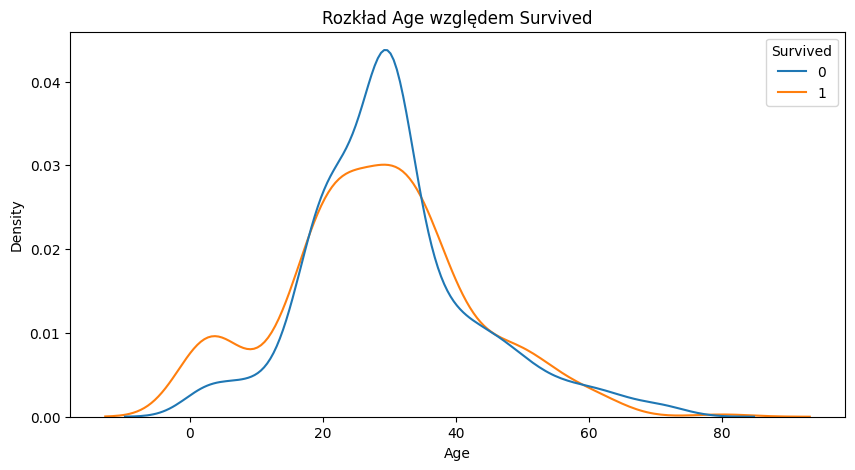

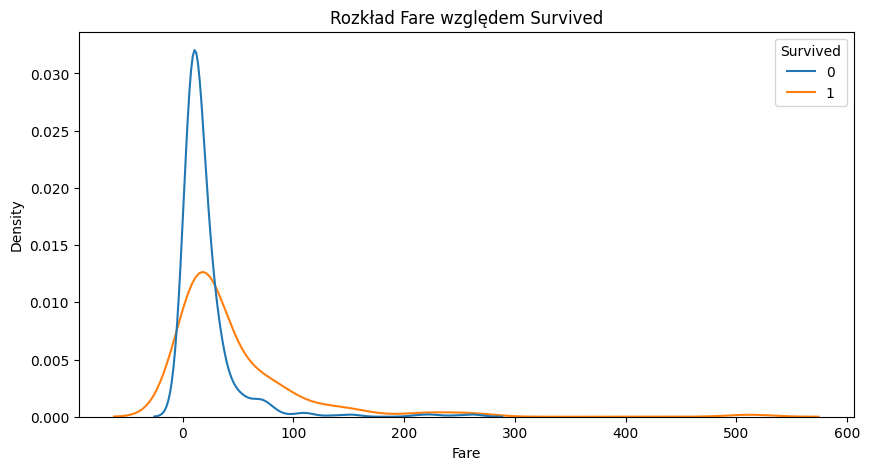

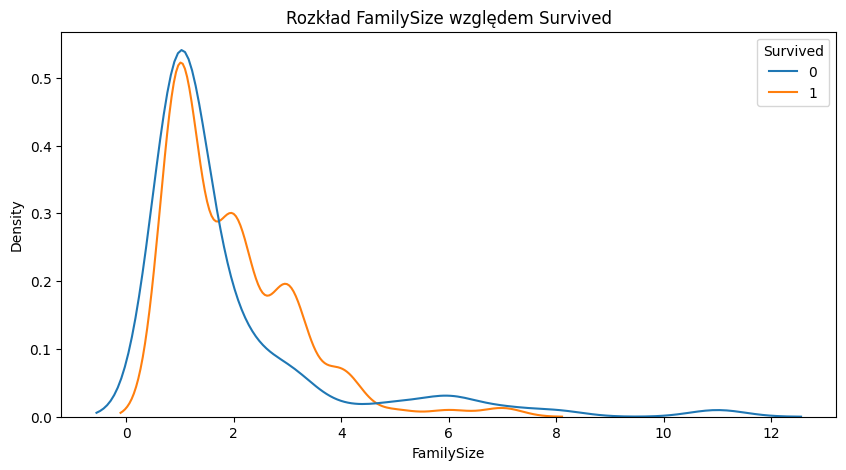

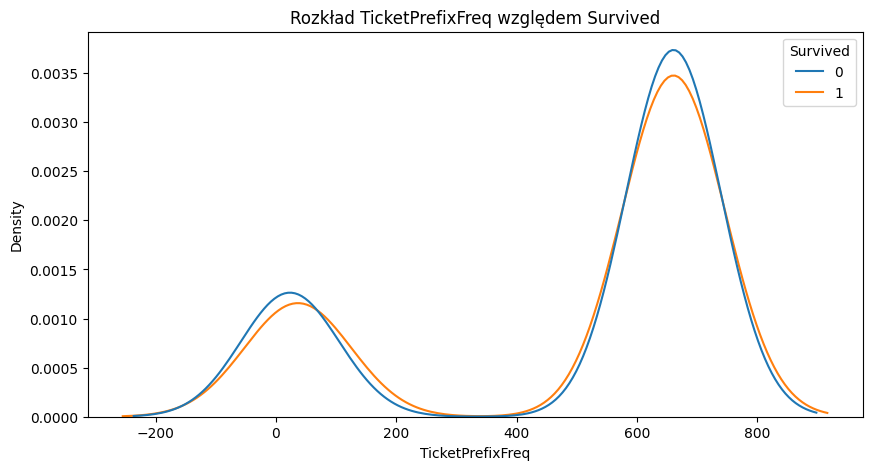

In [ ]:
for col in numeric_cols:
    plot_numeric_distribution(titanic_df, col, target='Survived')

Rozkłady kategorialne (z podziałem na Survived)

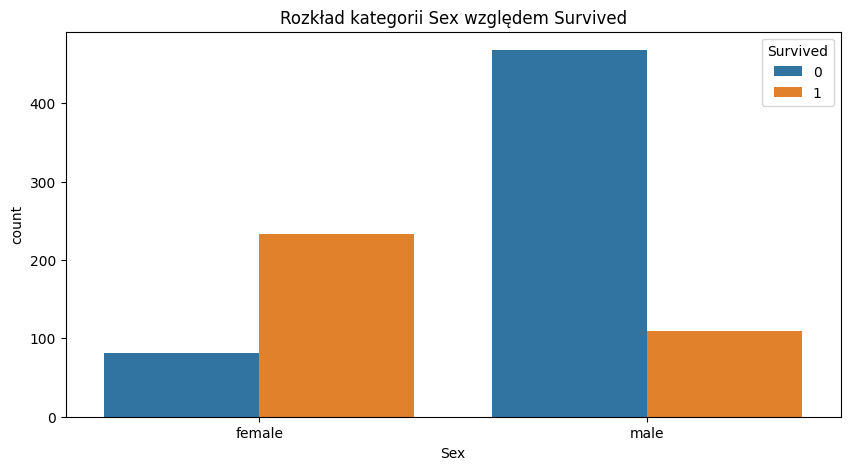

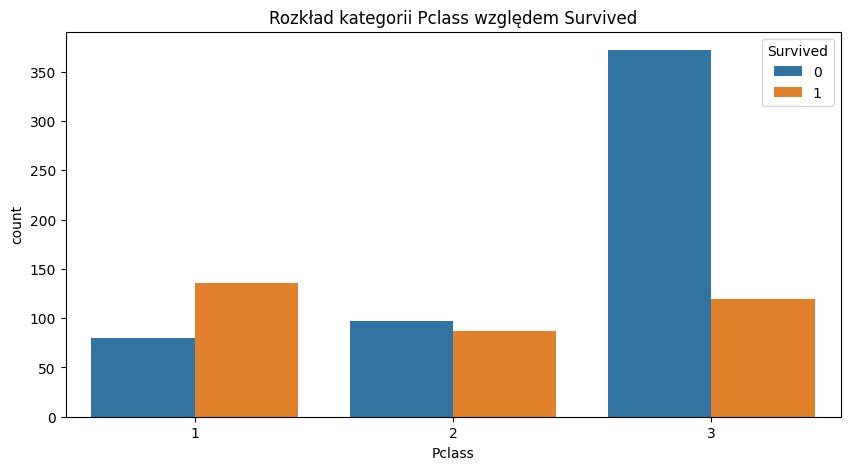

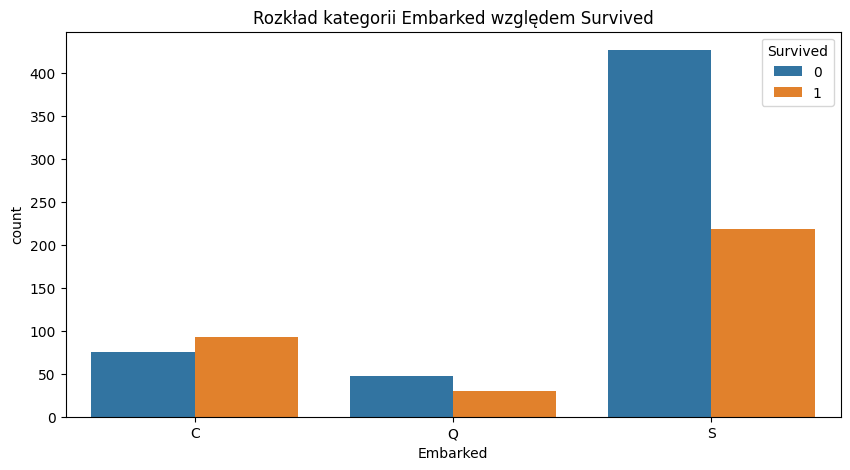

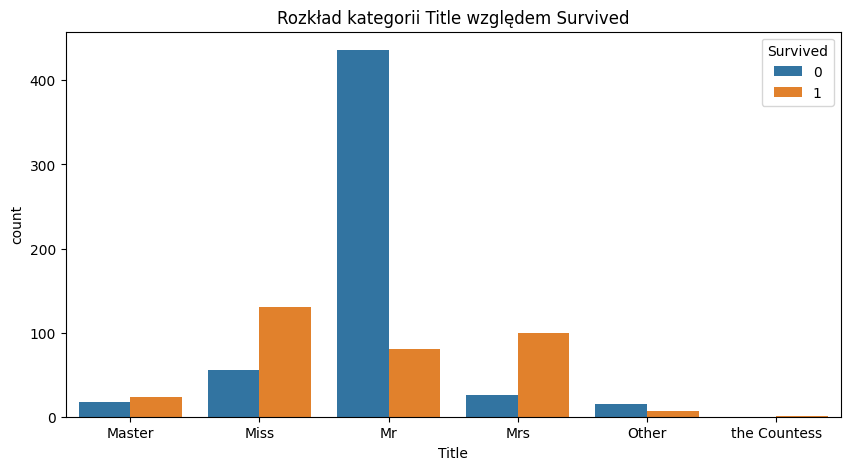

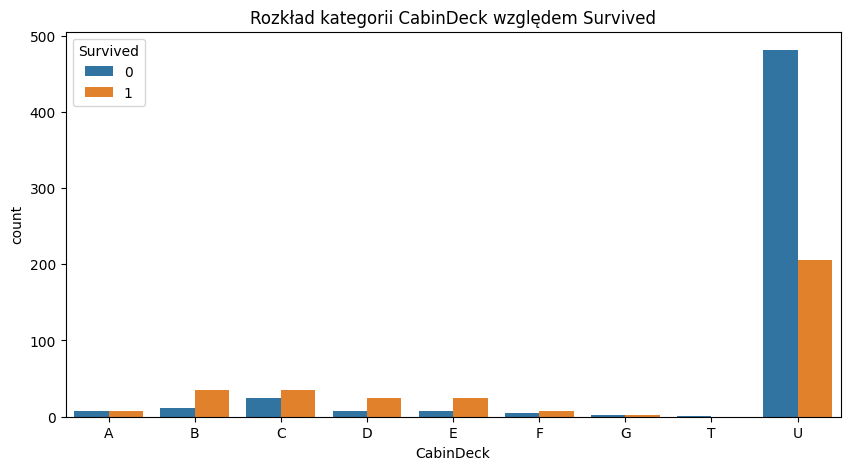

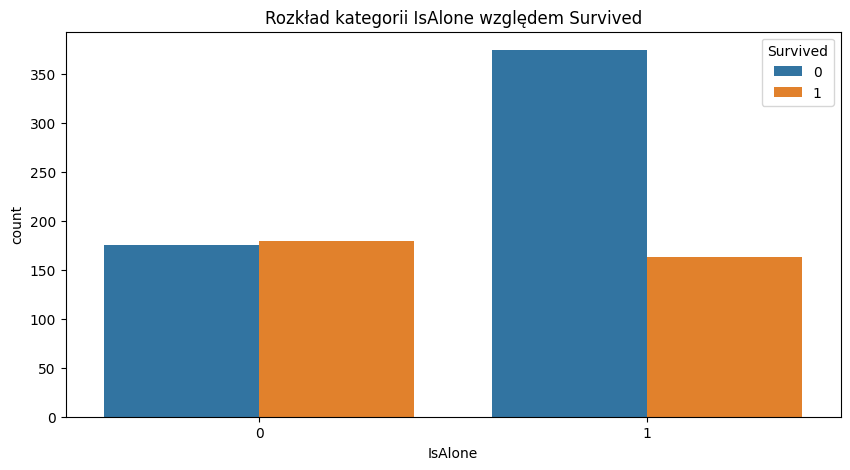

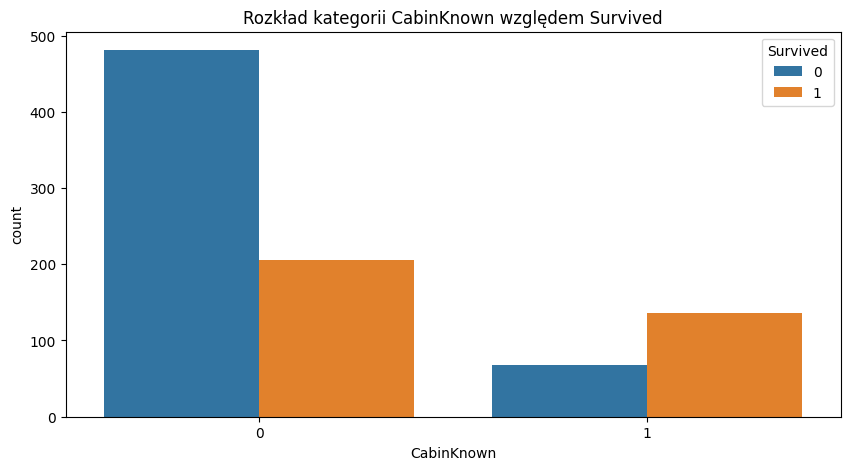

In [ ]:
for col in cat_cols:
    plot_categorical_distribution(titanic_df, col, target='Survived')

# 6. Wizualizacja par cech i korelacji

Boxplot - cechy numeryczne względem Survived

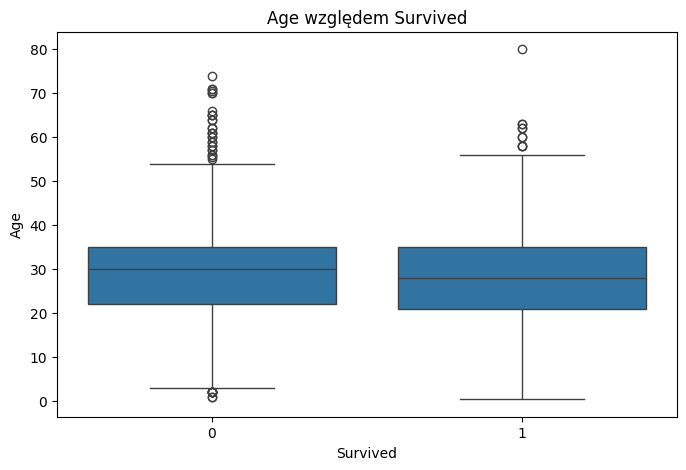

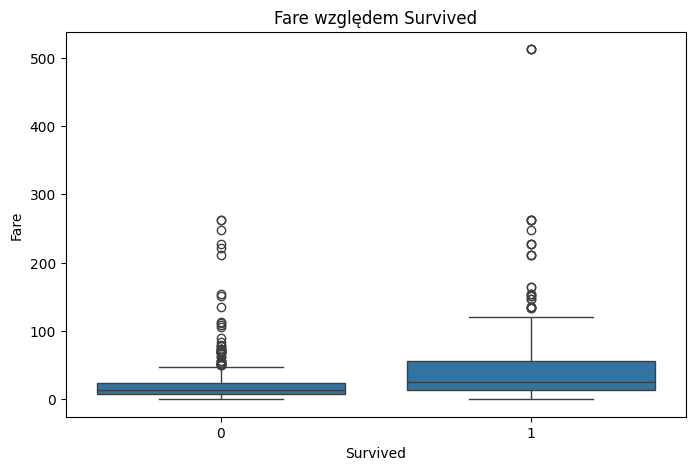

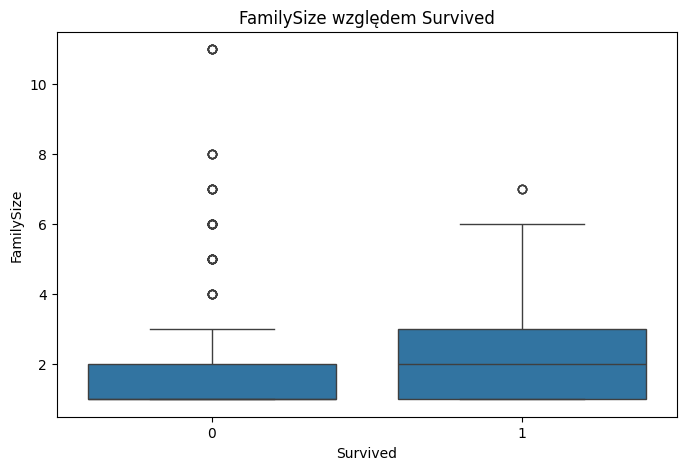

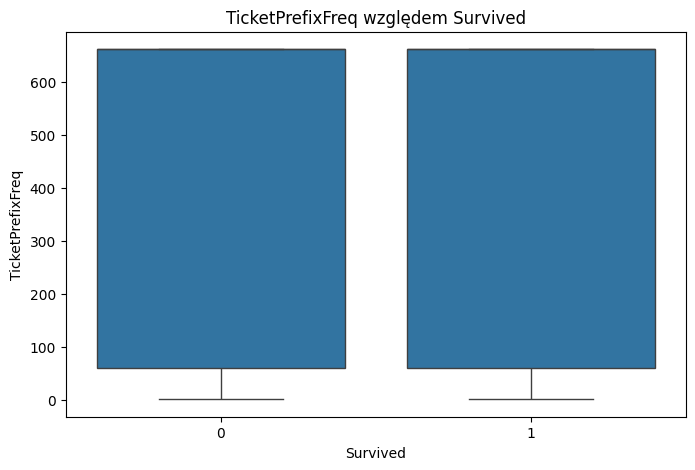

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Survived', y=col, data=titanic_df)
    plt.title(f"{col} względem Survived")
    plt.show()

Macierz korelacji cech numerycznych

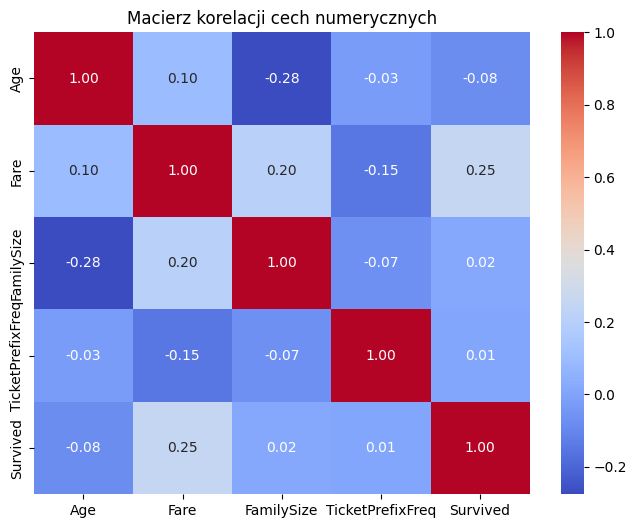

In [ ]:
plt.figure(figsize=(8,6))
corr = titanic_df[numeric_cols + ['Survived']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Macierz korelacji cech numerycznych")
plt.show()

# 7. Wartości odstające (outliery)

In [ ]:
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_bound = Q1 - 1.5 * IQR
    high_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < low_bound) | (df[col] > high_bound)]
    return outliers

for col in numeric_cols:
    outliers = detect_outliers(titanic_df, col)
    print(f"{col}: znaleziono {len(outliers)} wartości odstających.")


Age: znaleziono 35 wartości odstających.
Fare: znaleziono 110 wartości odstających.
FamilySize: znaleziono 91 wartości odstających.
TicketPrefixFreq: znaleziono 0 wartości odstających.


Rzadkie kategorie w kolumnach kategorialnych

In [ ]:
for col in cat_cols:
    counts = titanic_df[col].value_counts()
    rare = counts[counts < 5]
    if not rare.empty:
        print(f"Rzadkie kategorie w {col}:\n{rare}\n")

Rzadkie kategorie w Title:
Title
the Countess    1
Name: count, dtype: int64

Rzadkie kategorie w CabinDeck:
CabinDeck
G    4
T    1
Name: count, dtype: int64



# 8. Kodowanie zmiennych kategorialnych

Binary encoding

In [ ]:
titanic_df['Sex_bin'] = titanic_df['Sex'].map({'male': 0, 'female': 1})

One-hot encoding dla wybranych cech kategorialnych

In [ ]:
dummy_cols = ['Embarked', 'Title', 'CabinDeck']
titanic_df = pd.get_dummies(titanic_df, columns=dummy_cols, prefix=['Emb', 'Title', 'Deck'], drop_first=True)

Porządkowanie Pclass (ordinal)

In [ ]:
titanic_df['Pclass_ord'] = titanic_df['Pclass'].astype(int)

# 9. Finalny zbiór i zapis

In [ ]:
keep_cols = [
    'Survived', 'Pclass_ord', 'Sex_bin', 'Age', 'SibSp', 'Parch', 'Fare',
    'FamilySize', 'IsAlone', 'CabinKnown', 'TicketPrefixFreq'
]
final_dummy_cols = [col for col in titanic_df.columns if col.startswith('Emb_') or col.startswith('Title_') or col.startswith('Deck_')]
final_df = titanic_df[keep_cols + final_dummy_cols]

print("Braki w finalnym zbiorze:", final_df.isnull().sum().sum())

final_df.to_csv("titanic_cleaned.csv", index=False)
display(final_df.head())

Braki w finalnym zbiorze: 0


,Survived,Pclass_ord,Sex_bin,Age,SibSp,Parch,Fare,FamilySize,IsAlone,CabinKnown,...,Title_Other,Title_the Countess,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,2,0,0,...,False,False,False,False,False,False,False,False,False,True
2,1,1,1,38.0,1,0,71.2833,2,0,1,...,False,False,False,True,False,False,False,False,False,False
3,1,3,1,26.0,0,0,7.9250,1,1,0,...,False,False,False,False,False,False,False,False,False,True
4,1,1,1,35.0,1,0,53.1000,2,0,1,...,False,False,False,True,False,False,False,False,False,False
5,0,3,0,35.0,0,0,8.0500,1,1,0,...,False,False,False,False,False,False,False,False,False,True


# 10. Wnioski

- Młodsi pasażerowie mieli większe szanse na przeżycie niż starsi.

- Wyższa cena biletu korelowała z wyższą przeżywalnością.

- Kobiety miały znacznie większe szanse na przeżycie niż mężczyźni.

- Pasażerowie pierwszej klasy przeżywali częściej niż z niższych klas.

- Osoby podróżujące samotnie miały nieco wyższe szanse na przeżycie niż duże rodziny.

- Tytuł pasażera (np. Mrs, Miss) był wskaźnikiem statusu i wpływał na przeżywalność.

- Znana kabina i przypisany pokład były powiązane z większym prawdopodobieństwem przeżycia.